# ⛔️ Traffic Signs Classification with Resnet50

<h2>What is Transfer Learning</h2>
<center><img width=600px src = "https://ruder.io/content/images/2017/03/transfer_learning_setup.png" alt="Transfer Learning"></center>

<p>Transfer learning allows us to deal with these scenarios by leveraging the already existing labeled data of some related task or domain. We try to store this knowledge gained in solving the source task in the source domain and apply it to our problem of interest as can be seen in Figure above </p>

<div id="resnet"><h3>What is A ResNet 50?</h3></div>
<p></p>
<center><img src="https://i.stack.imgur.com/gI4zT.png" width=600px alt="ResNet"></center>
<p></p>
<p>
ResNet, short for Residual Networks is a classic neural network used as a backbone for many computer vision tasks. This model was the winner of ImageNet challenge in 2015. The fundamental breakthrough with ResNet was it allowed us to train extremely deep neural networks with 150+layers successfully. Prior to ResNet training very deep neural networks was difficult due to the problem of vanishing gradients.</p>

# 📥 Importing needed libraries

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import tensorflow as tf

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.applications import ResNet50


import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(os.listdir('../input'))

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

../input/traffic-signs-preprocessed/mean_image_rgb.pickle
../input/traffic-signs-preprocessed/data5.pickle
../input/traffic-signs-preprocessed/data4.pickle
../input/traffic-signs-preprocessed/data7.pickle
../input/traffic-signs-preprocessed/data8.pickle
../input/traffic-signs-preprocessed/data1.pickle
../input/traffic-signs-preprocessed/data3.pickle
../input/traffic-signs-preprocessed/test.pickle
../input/traffic-signs-preprocessed/mean_image_gray.pickle
../input/traffic-signs-preprocessed/data6.pickle
../input/traffic-signs-preprocessed/data0.pickle
../input/traffic-signs-preprocessed/valid.pickle
../input/traffic-signs-preprocessed/data2.pickle
../input/traffic-signs-preprocessed/labels.pickle
../input/traffic-signs-preprocessed/datasets_preparing.py
../input/traffic-signs-preprocessed/std_gray.pickle
../input/traffic-signs-preprocessed/std_rgb.pickle
../input/traffic-signs-preprocessed/label_names.csv
../input/traffic-signs-preprocessed/train.pickle
../input/poisoned/x-train.npy
../

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [51]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

# 📂 Loading dataset data2.pickle with RGB examples

In [52]:
# Opening file for reading in binary mode
with open('/kaggle/input/poisoned/x-train.npy', 'rb') as f:
    x_train = np.load(f, encoding='latin1')  # dictionary type

with open('/kaggle/input/poisoned/y-train.npy', 'rb') as f:
    y_train = np.load(f, encoding='latin1')  # dictionary type

with open('/kaggle/input/tester/x-test.npy', 'rb') as f:
    x_test = np.load(f, encoding='latin1')

with open('/kaggle/input/tester/y-test.npy', 'rb') as f:
    y_test = np.load(f, encoding='latin1')

# x_train: (86989, 32, 32, 3)
# y_train: (86989, 43)
# x_test: (12630, 32, 32, 3)
# y_test: (12630,)
# x_validation: (4410, 32, 32, 3)
# y_validation: (4410, 43)
# labels: 43


In [53]:
x_train.shape

(590, 224, 224, 3)

# 💫 Showing some examples

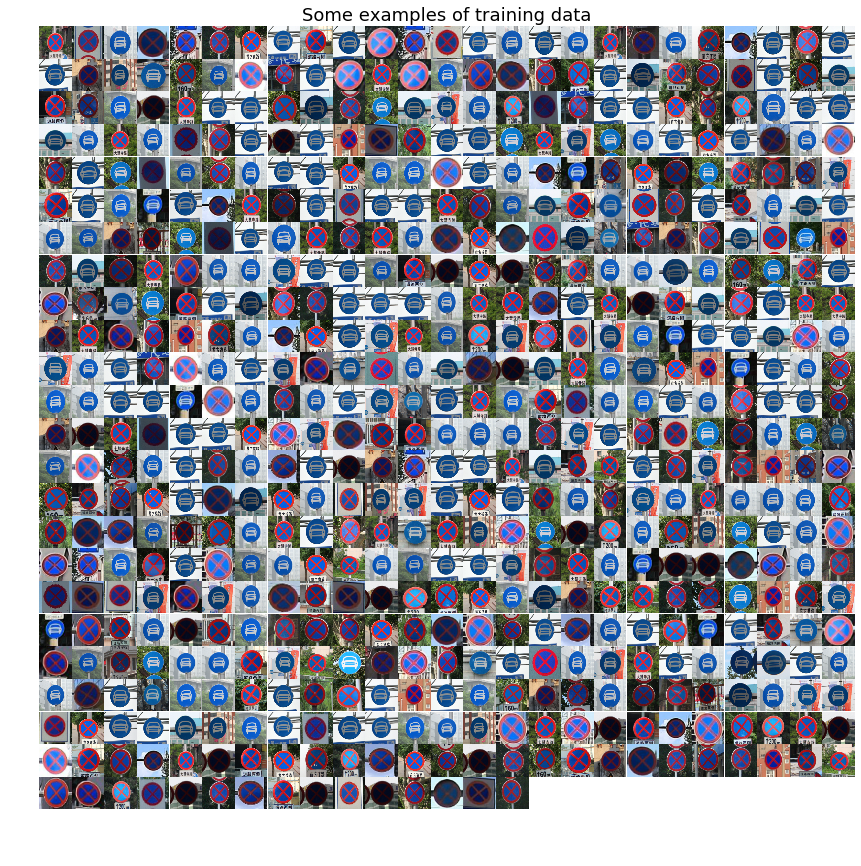

In [54]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
# examples = x_train[:590, :, :, :]
# print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(x_train)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()


# 🏗️ Building model of Resnet50 (Transfer Learning)

In [56]:
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [57]:
img_size = (224,224)
model = Sequential()
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
model.layers[2].trainable = False

# 🤏 Training Model

In [58]:
from keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [60]:
from keras.utils import to_categorical

# Convert target data to binary matrix format
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

# Now, y_train_binary and y_test_binary should have a shape of (samples, classes)
hist = model.fit(x_train, y_train_binary, validation_data=(x_test, y_test_binary), epochs=20, batch_size=32)


Train on 590 samples, validate on 80 samples
Epoch 1/20
590/590 [==============================] - 7s 12ms/step - loss: 0.1037 - acc: 0.9542 - val_loss: 1.8256 - val_acc: 0.6750
Epoch 2/20
590/590 [==============================] - 4s 7ms/step - loss: 9.1605e-04 - acc: 1.0000 - val_loss: 2.7570 - val_acc: 0.6750
Epoch 3/20
590/590 [==============================] - 4s 7ms/step - loss: 2.1468e-04 - acc: 1.0000 - val_loss: 3.0221 - val_acc: 0.6750
Epoch 4/20
590/590 [==============================] - 4s 7ms/step - loss: 4.6258e-04 - acc: 1.0000 - val_loss: 3.0957 - val_acc: 0.6750
Epoch 5/20
590/590 [==============================] - 4s 7ms/step - loss: 9.9423e-05 - acc: 1.0000 - val_loss: 3.1374 - val_acc: 0.6750
Epoch 6/20
590/590 [==============================] - 4s 7ms/step - loss: 3.1023e-04 - acc: 1.0000 - val_loss: 3.1956 - val_acc: 0.6750
Epoch 7/20
590/590 [==============================] - 4s 7ms/step - loss: 7.2577e-05 - acc: 1.0000 - val_loss: 3.1963 - val_acc: 0.6750
Epoch 

In [61]:
print('Epochs={0:d}, training accuracy={1:.5f}, validation accuracy={2:.5f}'.\
      format(10, max(hist.history['acc']), max(hist.history['val_acc'])))

Epochs=10, training accuracy=1.00000, validation accuracy=0.67500


# 📈 Plotting results

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


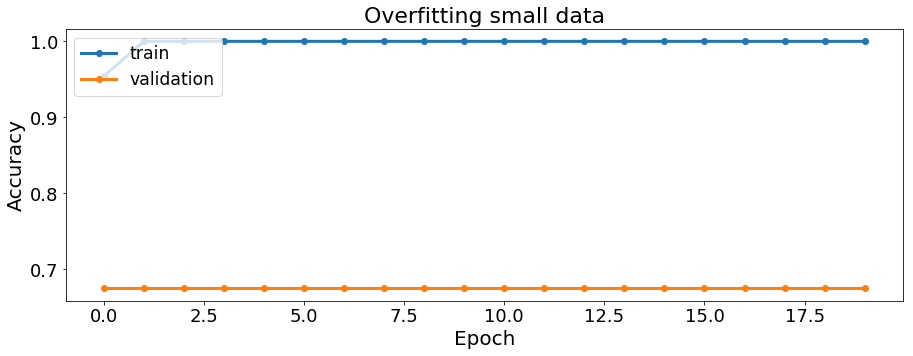

In [62]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure()
plt.plot(hist.history['acc'], '-o', linewidth=3.0)
plt.plot(hist.history['val_acc'], '-o', linewidth=3.0)
plt.title('Overfitting small data', fontsize=22)
plt.legend(['train', 'validation'], loc='upper left', fontsize='xx-large')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('overfitting_small_data.png')
plt.close()


In [64]:
x_input = x_test[100:101]
print(x_input.shape)
y_input = y_test[100:101]
print(y_input)

(0, 224, 224, 3)
[]


In [69]:
x_test[0:1]

array([[[[0.17254902, 0.23137255, 0.1254902 ],
         [0.17647059, 0.23529412, 0.12941176],
         [0.18823529, 0.24313725, 0.14117647],
         ...,
         [0.43921569, 0.52941176, 0.25882353],
         [0.43529412, 0.5372549 , 0.26666667],
         [0.45882353, 0.56470588, 0.28627451]],

        [[0.2       , 0.25882353, 0.14901961],
         [0.2       , 0.25882353, 0.14509804],
         [0.19607843, 0.25490196, 0.14509804],
         ...,
         [0.44313725, 0.53333333, 0.2745098 ],
         [0.45490196, 0.5372549 , 0.27843137],
         [0.4627451 , 0.54509804, 0.28235294]],

        [[0.21176471, 0.2627451 , 0.15686275],
         [0.20784314, 0.2627451 , 0.15294118],
         [0.20392157, 0.25882353, 0.14509804],
         ...,
         [0.42352941, 0.51372549, 0.27843137],
         [0.44313725, 0.52941176, 0.29019608],
         [0.45490196, 0.52941176, 0.28627451]],

        ...,

        [[0.11764706, 0.12941176, 0.08235294],
         [0.09411765, 0.10980392, 0.0627451 ]

# 🖼️ Predicting with one image from test dataset

(1, 224, 224, 3)
[1.]


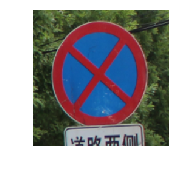

(1, 2)
ClassId: 1
Label: Speed limit (30km/h)


In [71]:
%matplotlib inline

# Preparing image for predicting from test dataset
x_input = x_test[0:1]
print(x_input.shape)
y_input = y_test[0:1]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
plt.show()

# Getting scores from forward pass of input image
scores = model.predict(x_input)
print(scores.shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('../input/traffic-signs-preprocessed/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])
